# Illegal Mining Dection Notebook <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

This notebook uses changes in NDVI to identify vegetation change. 
The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. 
Significant reductions in vegetation are coincident with land change. 
In some cases these changes could be deforestation. 
Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. 
In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.


## Description
The notebook demonstrates how to:

1. Load data for a given location and time period
2. Calculate the vegetation change using NDVI
3. Compare the water extent for two time periods
4. Combine all plot to show illegal mining area

***

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
from matplotlib.cm import RdYlGn
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

sys.path.append('../Scripts')

from odc.algo import to_f32, from_float, xr_geomedian

from deafrica_bandindices import calculate_indices
from deafrica_datahandling import load_ard, mostcommon_crs, wofs_fuser
from deafrica_plotting import display_map, rgb

In [2]:
dc = datacube.Datacube(app='illegal_mining')

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [3]:
# Select an analysis region 
# Consider using Cloud Statistics notebook to find clear scenes

lat_range = (6.370517, 6.287974)
lon_range = (-1.907504, -1.832074)


In [4]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(lon_range, lat_range)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

In [5]:
# Select the baseline time period (start and end)
baseline_time_period = '2013'

# Select the analysis time period (start and end)
analysis_time_period = '2019'


## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>  

In [6]:
#Create a query object

query = {
    'x': lon_range,
    'y': lat_range,
    'group_by': 'solar_day',
    'resolution': (-30, 30),
  'align': (15, 15),
   #'measurements' : ["red", "green", "blue", "nir", "swir1", "swir2"]
}
products = ["ls8_usgs_sr_scene"]
# find the right crs for the location
crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

query['time'] = (baseline_time_period)
baseline_ds = load_ard(dc=dc, products=products, output_crs=crs, min_gooddata=0.70, **query)

query['time'] = (analysis_time_period)
analysis_ds = load_ard(dc=dc, products=products, output_crs=crs, min_gooddata=0.70, **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 1 out of 11 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 1 out of 17 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps


In [7]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

#scale the values using the f_32 util function
baseline_ds_scaled = to_f32(baseline_ds, scale=scale, offset=offset)
baseline_ds_geomedian = xr_geomedian(baseline_ds_scaled, num_threads=1, eps=1e-7, nocheck=True)
baseline_ds_geomedian = baseline_ds_geomedian.compute()
baseline_ds_geomedian = from_float(baseline_ds_geomedian, dtype='float32', nodata=np.nan, scale=1/scale,  offset=-offset/scale)


analysis_ds_scaled = to_f32(analysis_ds, scale=scale, offset=offset)
analysis_ds_geomedian = xr_geomedian(analysis_ds, num_threads=1, eps=1e-7, nocheck=True)
analysis_ds_geomedian = analysis_ds_geomedian.compute()
analysis_ds_geomedian = from_float(analysis_ds_geomedian, dtype='float32', nodata=np.nan, scale=1/scale,  offset=-offset/scale)

In [8]:
baseline_ds_geomedian = calculate_indices(baseline_ds_geomedian, ['NDVI'], collection='c1')
analysis_ds_geomedian = calculate_indices(analysis_ds_geomedian, ['NDVI'], collection='c1')

## <span id="anomalies">Calculate Anomaly Product [&#9652;](#top)</span>  

In [9]:
parameter_anomaly = analysis_ds_geomedian.NDVI - baseline_ds_geomedian.NDVI

## Show Baseline RGB, Analysis RGB and Anomaly Products

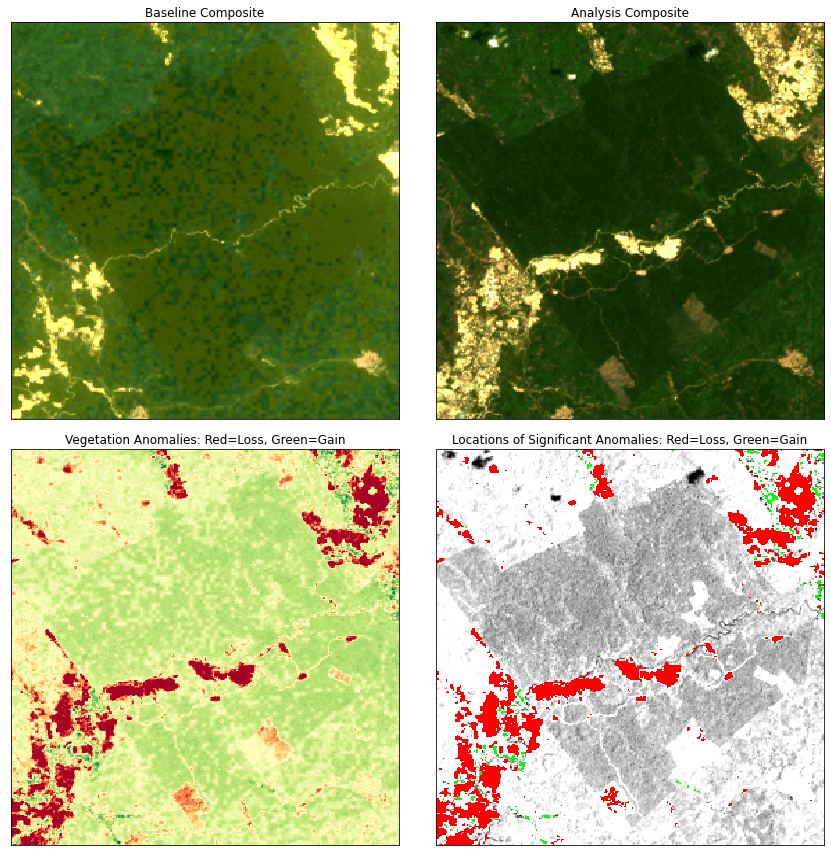

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))


# Use the middle values of the data (2% to 98%) to brighten the image

baseline_rgb = baseline_ds_geomedian[['red', 'green', 'blue']].to_array()
analysis_rgb = analysis_ds_geomedian[['red', 'green', 'blue']].to_array()


lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values, analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values, analysis_rgb.quantile(up_qtl).values)
# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold

## Plot #1 = Baseline RGB (upper left)
baseline_rgb.plot.imshow(ax=ax[0,0], vmin=baseline_rgb.quantile(lw_qtl).values, vmax=baseline_rgb.quantile(up_qtl).values)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=analysis_rgb.quantile(lw_qtl).values, vmax= analysis_rgb.quantile(up_qtl).values)

## Plot #3 = Total Anomaly (lower left)
parameter_anomaly.plot(ax=ax[1, 0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(analysis_ds_geomedian[plt4_bkg_band].values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background (vs. 0.02 and 0.98)
min_bkg = np.nanquantile(analysis_ds_geomedian[plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(analysis_ds_geomedian[plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Extreme anomaly overlays
loss_range  = parameter_anomaly < -0.2
gain_range  = parameter_anomaly > 0.2
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(analysis_ds_geomedian.coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr, name='rgb', dims=['rgb'], coords={'rgb': rgb_coord_arr})

plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, dims=['y','x','rgb'],  coords=plt4_coords)
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Calculate Pixel Counts within Thresholds

In [11]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [12]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# NDVI losses are typically <0.2 for deforestation
minimum_change = -0.7
maximum_change = -0.2

In [13]:
# This output is a count of the pixels that fall within each threshold range
threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 85680, 'total_non_cloudy': 85680, 'inside': 6760, 'outside': 78920}

In [14]:
# This output is a percentage of the pixels that fall within each threshold range
threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 7.889822595704948,
 'percent_outside_threshold': 92.11017740429504,
 'percent_clouds': 0.0}

# Determine the change in water area of the Two year

In [15]:
query['time'] = (baseline_time_period)
ds_wofs_1 = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs=crs,
             fuse_func=wofs_fuser,
             **query
            )

query['time'] = (analysis_time_period)
ds_wofs_2 = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs=crs,
             fuse_func=wofs_fuser,
             **query
            )

In [16]:
ds_water_baseline = ds_wofs_1.water.isin([128])
ds_water_analysis = ds_wofs_2.water.isin([128])

In [17]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [18]:
ds_water_area_baseline = ds_water_baseline.sum(dim=['x', 'y']) * area_per_pixel
ds_water_area_analysis = ds_water_analysis.sum(dim=['x', 'y']) * area_per_pixel

In [19]:
baseline_max_water, analysis_max_water = max(ds_water_area_baseline) ,  max(ds_water_area_analysis)

In [20]:
max_water_baseline = ds_water_baseline.sel(time=baseline_max_water.time.values)
max_water_analysis = ds_water_analysis.sel(time=analysis_max_water.time.values)

In [21]:
#The dataset array is transform to 1 and 0 using the `astype(int)` function.
change = max_water_analysis.astype(int) - max_water_baseline.astype(int)

#The various scenarios are extracted from the `change` variable for the two years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (max_water_analysis == 1))

#Water loss = -1
water_disappeared = change.where(change == -1)

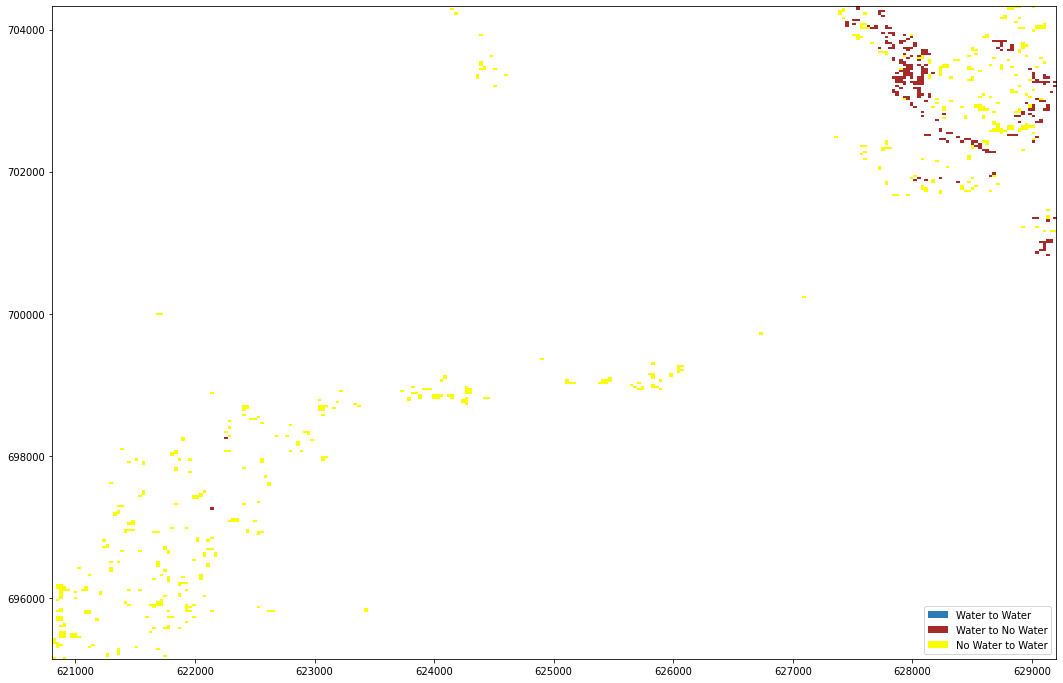

In [22]:
water_appeared_color = '#faff00'
water_disappeared_color = 'Brown'
stable_color = '#2c7bb6'

water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False, size=12)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [ Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Water to Water', 'Water to No Water' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'lower right'
    )

# Combine both plots to determine mining areas

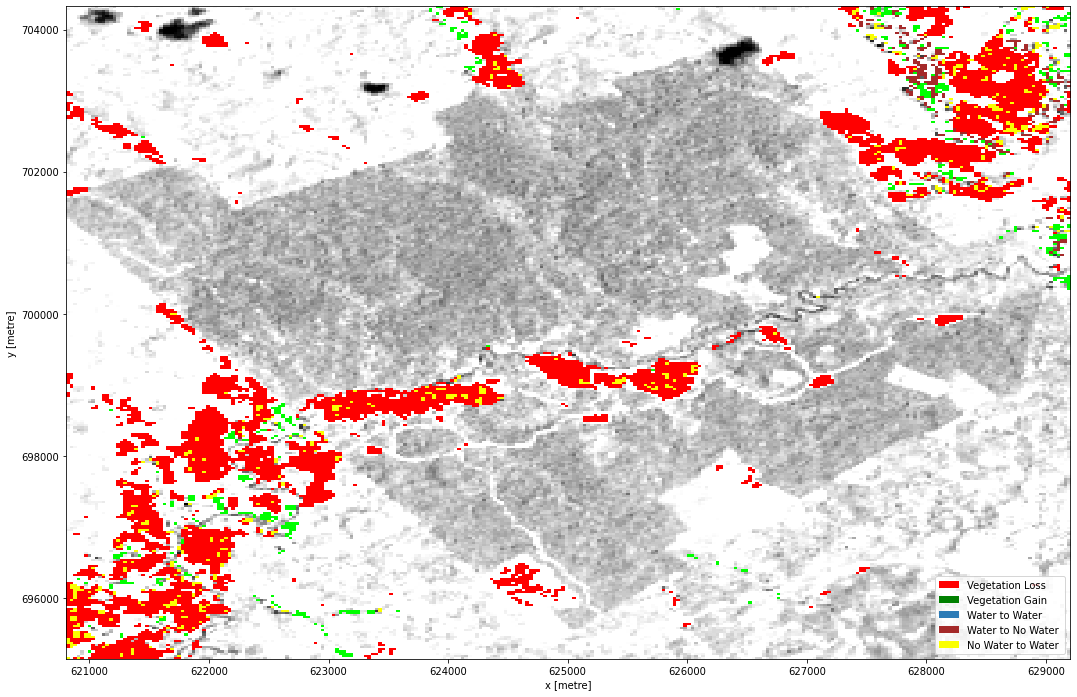

In [23]:
water_appeared_color = '#faff00'
water_disappeared_color = 'Brown'
stable_color = '#2c7bb6'
vegetation_loss = 'Red'
vegetation_gain = 'Green'


plt4_rgb_da.plot.imshow(size=12)
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=vegetation_loss), Patch(facecolor=vegetation_gain), Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Vegetation Loss','Vegetation Gain','Water to Water', 'Water to No Water ' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'lower right'
    )

## Next steps


You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.



***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)